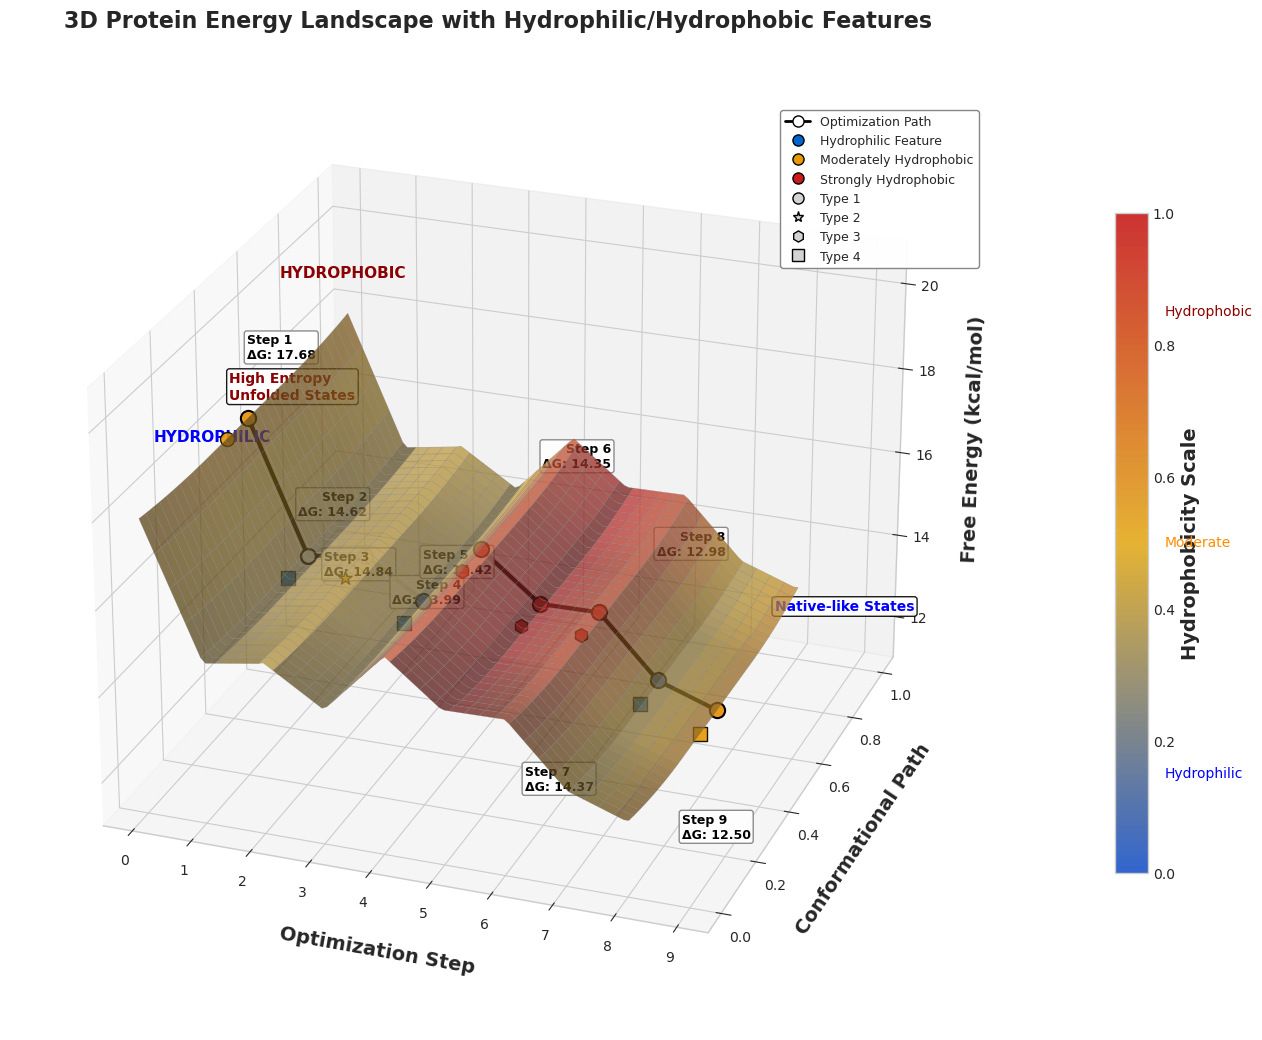

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data - keep original barriers
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = [
    "Mutation 1",
    "Mutation 2",
    "Mutation 3",
    "Mutation 4",
    "Mutation 5",
    "Mutation 6",
    "Mutation 7",
    "Mutation 8",
    "Mutation 9"
]

# Add features - hydrophobicity scales (more abstract)
# Higher values = more hydrophobic
hydrophobicity_values = [2.5, 1.8, 2.0, 1.8, 4.2, 4.5, 3.8, 1.9, 2.8]

# Define hydrophilic/hydrophobic classification
def classify_aa(h_value):
    if h_value < 2.0:
        return "Hydrophilic"
    elif h_value < 3.0:
        return "Moderate"
    else:
        return "Hydrophobic"

# Get classification for each step
mutation_class = [classify_aa(h) for h in hydrophobicity_values]

# Volume values (approximate) - we'll keep concept but not name AAs
mutation_volume = [108.5, 88.6, 116.0, 88.6, 140.0, 166.7, 166.7, 162.9, 189.9]

# More distinct color scheme based on hydrophobicity
def hydrophobicity_color(h_value):
    if h_value < 2.0:  # Hydrophilic
        return (0.2, 0.4, 0.8)  # Deeper blue
    elif h_value < 3.0:  # Moderately hydrophobic
        return (0.9, 0.6, 0.1)  # Distinct orange
    else:  # Strongly hydrophobic
        return (0.8, 0.2, 0.2)  # Deeper red

colors_custom = [hydrophobicity_color(h) for h in hydrophobicity_values]

# Create figure with more space
fig = plt.figure(figsize=(14, 12))

# Create 3D surface plot
ax = plt.axes(projection='3d')

# Create smooth surface function for 3D plot with enhanced features
def create_smooth_surface(levels, barriers, hydrophobicity_values, volume_values):
    x = np.linspace(0, len(levels)-1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    hydro_surface = np.zeros_like(X)
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            xval = X[i][j]
            if xval <= levels[0]:
                Z[i][j] = barriers[0]
                hydro_surface[i][j] = hydrophobicity_values[0]
            elif xval >= levels[-1]:
                Z[i][j] = barriers[-1]
                hydro_surface[i][j] = hydrophobicity_values[-1]
            else:
                idx = np.searchsorted(levels, xval)
                t = (xval - levels[idx-1]) / (levels[idx] - levels[idx-1])
                Z[i][j] = barriers[idx-1] + t * (barriers[idx] - barriers[idx-1])
                hydro_surface[i][j] = hydrophobicity_values[idx-1] + t * (hydrophobicity_values[idx] - hydrophobicity_values[idx-1])
            
            # Create funnel shape
            center_y = 0.5
            dist_from_center = abs(Y[i][j] - center_y)
            
            # Make a deeper valley along the center path
            if dist_from_center < 0.2:
                variance = 0
            else:
                # Add volume influence to the landscape
                vol_idx = min(int(xval), len(volume_values)-1)
                if vol_idx < 0:
                    vol_idx = 0
                volume_factor = volume_values[vol_idx] / max(volume_values)
                variance = 3 * (dist_from_center - 0.2)**2 * volume_factor
                
            Z[i][j] += variance
            
    return X, Y, Z, hydro_surface

X_smooth, Y_smooth, Z_smooth, hydro_surface = create_smooth_surface(
    levels, barriers, hydrophobicity_values, mutation_volume)

# Create custom colormap for hydrophobicity with more distinct colors
hydro_cmap = LinearSegmentedColormap.from_list(
    'hydrophobicity', 
    [(0, (0.2, 0.4, 0.8)),      # Deep blue (hydrophilic)
     (0.5, (0.9, 0.7, 0.2)),    # Distinct orange (moderate)
     (1, (0.8, 0.2, 0.2))],     # Deep red (hydrophobic)
    N=100
)

# Plot the smooth surface colored by hydrophobicity
surf = ax.plot_surface(X_smooth, Y_smooth, Z_smooth, 
                     facecolors=hydro_cmap(hydro_surface/max(hydrophobicity_values)),
                     alpha=0.75, 
                     edgecolor='gray',
                     rstride=3, cstride=3,
                     linewidth=0.2, 
                     antialiased=True,
                     shade=True)

# Plot a highlighted path on the surface
path_y = np.ones(len(levels)) * 0.5
ax.plot(levels, path_y, barriers, color='black', linewidth=3, 
       marker='o', markersize=10, markerfacecolor='white', markeredgecolor='black', 
       label="Optimization Path")

# Add hydrophilic/hydrophobic regions annotation - moved out of the way
ax.text(-0.5, 0.2, 18.5, "HYDROPHILIC", fontsize=11, color='blue', fontweight='bold')
ax.text(-0.5, 0.8, 19.5, "HYDROPHOBIC", fontsize=11, color='darkred', fontweight='bold')

# Create text position patterns that ensure no overlaps
# Pattern 1: Zigzag vertically, alternating front/back
text_positions = [
    {"x": 0, "y": 0.5, "z": 19, "ha": "left", "va": "bottom"},    # Step 1 (top left)
    {"x": 1, "y": 0.8, "z": 14, "ha": "right", "va": "bottom"},   # Step 2 (top right)
    {"x": 2, "y": 0.3, "z": 16, "ha": "left", "va": "top"},       # Step 3 (bottom left)
    {"x": 3, "y": 0.7, "z": 12.8, "ha": "right", "va": "bottom"}, # Step 4 (top right)
    {"x": 4, "y": 0.2, "z": 17, "ha": "left", "va": "top"},       # Step 5 (bottom left)
    {"x": 5, "y": 0.9, "z": 15.5, "ha": "right", "va": "bottom"}, # Step 6 (top right)
    {"x": 6, "y": 0.1, "z": 13, "ha": "left", "va": "top"},       # Step 7 (bottom left)
    {"x": 7, "y": 0.9, "z": 13.8, "ha": "right", "va": "bottom"}, # Step 8 (top right)
    {"x": 8, "y": 0.3, "z": 11.2, "ha": "left", "va": "top"}      # Step 9 (bottom left)
]

# Add points for each mutation with carefully positioned text to avoid overlap
for i in range(len(levels)):
    # More distinct markers
    ax.scatter(levels[i], 0.5, barriers[i], color=colors_custom[i], s=120, 
              edgecolor='black', linewidth=1.5, zorder=100)
    
    # Use the pre-defined non-overlapping positions
    pos = text_positions[i]
    
    # Shorter labels with minimum information
    level_label = f"Step {i+1}\nΔG: {barriers[i]:.2f}"
    ax.text(pos["x"], pos["y"], pos["z"], level_label,
           color='black', fontsize=9, ha=pos["ha"], va=pos["va"], fontweight='bold',
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2', edgecolor='gray'))

# Add feature symbols with different sizes and shapes based on properties
def add_feature_symbol(ax, x, y, z, symbol_type, hydro_value):
    # Color based on hydrophobicity - more distinct
    if hydro_value < 2.0:  # Hydrophilic
        color = (0.0, 0.4, 0.8)  # Deeper blue
    elif hydro_value < 3.0:  # Moderately hydrophobic
        color = (0.9, 0.6, 0.0)  # Distinct orange
    else:  # Strongly hydrophobic
        color = (0.8, 0.1, 0.1)  # Deeper red
        
    # Different marker shapes for different types
    if symbol_type == 0:
        marker = 'o'
    elif symbol_type == 2:
        marker = '*'
    elif symbol_type in [4, 5, 6]:
        marker = 'h'
    else:
        marker = 's'
        
    # Smaller markers to reduce visual clutter
    ax.scatter(x, y-0.1, z, color=color, s=100, marker=marker, 
              edgecolor='black', linewidth=1, alpha=0.9, zorder=100)

# Add feature representations along the path - without text to reduce clutter
for i in range(len(levels)):
    add_feature_symbol(ax, levels[i], 0.5, barriers[i], 
                     i, hydrophobicity_values[i])

# Add a colorbar for hydrophobicity with improved labels
cbar = fig.colorbar(cm.ScalarMappable(cmap=hydro_cmap), ax=ax, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Hydrophobicity Scale', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add text annotations for hydrophobicity scale - with more space
cbar.ax.text(1.5, 0.15, "Hydrophilic", fontsize=10, ha='left', va='center', color='blue')
cbar.ax.text(1.5, 0.5, "Moderate", fontsize=10, ha='left', va='center', color='darkorange')
cbar.ax.text(1.5, 0.85, "Hydrophobic", fontsize=10, ha='left', va='center', color='darkred')

# Add text for the energy landscape regions - moved to non-overlapping areas
ax.text(1, 0.15, 20, "High Entropy\nUnfolded States", fontsize=10, color='darkred', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2'))
ax.text(8, 0.85, 13, "Native-like States", fontsize=10, color='blue', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.2'))

# Add axes labels and title
ax.set_xlabel("Optimization Step", fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel("Conformational Path", fontsize=14, fontweight='bold', labelpad=15)
ax.set_zlabel("Free Energy (kcal/mol)", fontsize=14, fontweight='bold', labelpad=15)
ax.set_title("3D Protein Energy Landscape with Hydrophilic/Hydrophobic Features", 
           fontsize=16, fontweight='bold', pad=20)

# Adjust view angle for better visibility and to reduce overlaps
ax.view_init(elev=25, azim=-70)
ax.grid(True, linestyle='--', alpha=0.5)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim(-0.5, len(levels)+0.5)  # Extended range for better spacing
ax.set_zlim(11, 21)  # Extended range for text placement

# Add legend with clearer organization and spacing - moved to top right to avoid overlap
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='o', linestyle='-', 
               markerfacecolor='white', markeredgecolor='black',
               markersize=8, linewidth=2, label="Optimization Path"),
    plt.Line2D([0], [0], marker='o', color=(0.0, 0.4, 0.8), markeredgecolor='black',
               markersize=8, linewidth=0, label="Hydrophilic Feature"),
    plt.Line2D([0], [0], marker='o', color=(0.9, 0.6, 0.0), markeredgecolor='black',
               markersize=8, linewidth=0, label="Moderately Hydrophobic"),
    plt.Line2D([0], [0], marker='o', color=(0.8, 0.1, 0.1), markeredgecolor='black',
               markersize=8, linewidth=0, label="Strongly Hydrophobic"),
    plt.Line2D([0], [0], marker='o', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 1"),
    plt.Line2D([0], [0], marker='*', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 2"),
    plt.Line2D([0], [0], marker='h', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 3"),
    plt.Line2D([0], [0], marker='s', color='lightgray', markeredgecolor='black',
               markersize=8, linewidth=0, label="Type 4")
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9, 
         bbox_to_anchor=(1.0, 0.95), frameon=True, framealpha=0.95, edgecolor='gray')

plt.tight_layout(pad=3.0)
plt.show()

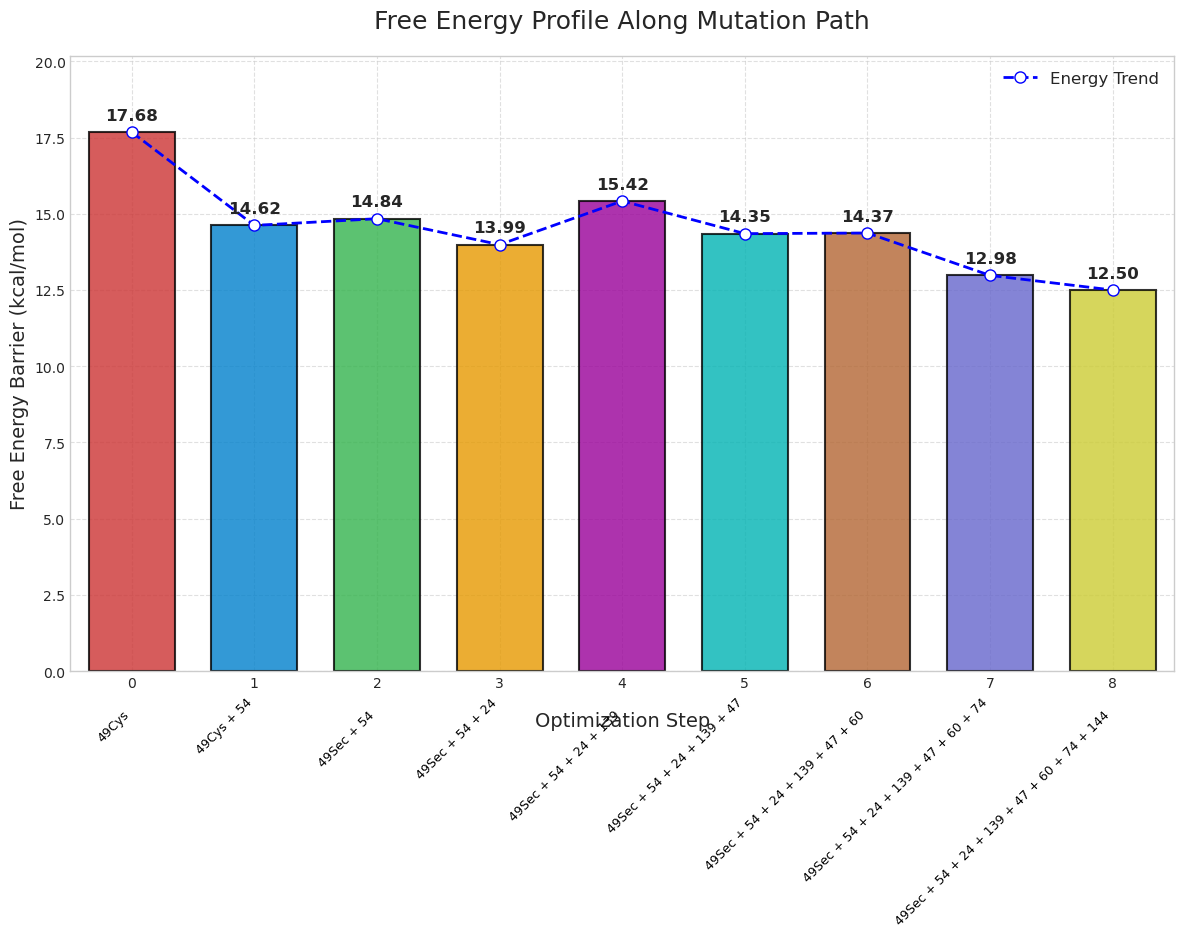

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74 + 144"
]

# Define a custom colormap with distinct colors
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8),  # Lavender for level 7
    (0.8, 0.8, 0.2)   # Yellow for level 8
]

# Create figure
plt.figure(figsize=(12, 8))

# Create bars with custom colors
for i, (lvl, val) in enumerate(zip(levels, barriers)):
    plt.bar(lvl, val, width=0.7, color=colors_custom[i], 
            edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    plt.text(lvl, val + 0.3, f"{val:.2f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add mutation labels underneath with rotation
for i, mutation in enumerate(mutations):
    if i % 2 == 0:  # Alternate label positioning for readability
        plt.text(i, -1.2, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')
    else:
        plt.text(i, -0.8, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')

# Add trend line
plt.plot(levels, barriers, 'o--', color='blue', markersize=8, 
         linewidth=2, markerfacecolor='white', markeredgecolor='blue',
         label="Energy Trend")

plt.title("Free Energy Profile Along Mutation Path", fontsize=18, pad=20)
plt.xlabel("Optimization Step", fontsize=14, labelpad=15)
plt.ylabel("Free Energy Barrier (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(levels, [f"{i}" for i in range(len(levels))])
plt.xlim(-0.5, max(levels) + 0.5)
plt.ylim(0, max(barriers) + 2.5)  # Extra space for labels and annotations

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add annotation explaining the trend
#plt.annotate('Progressive optimization \ntowards native state', 
          #  xy=(7, 13.5), xytext=(5, 16),
          #  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
          #  fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for mutation labels
plt.show()

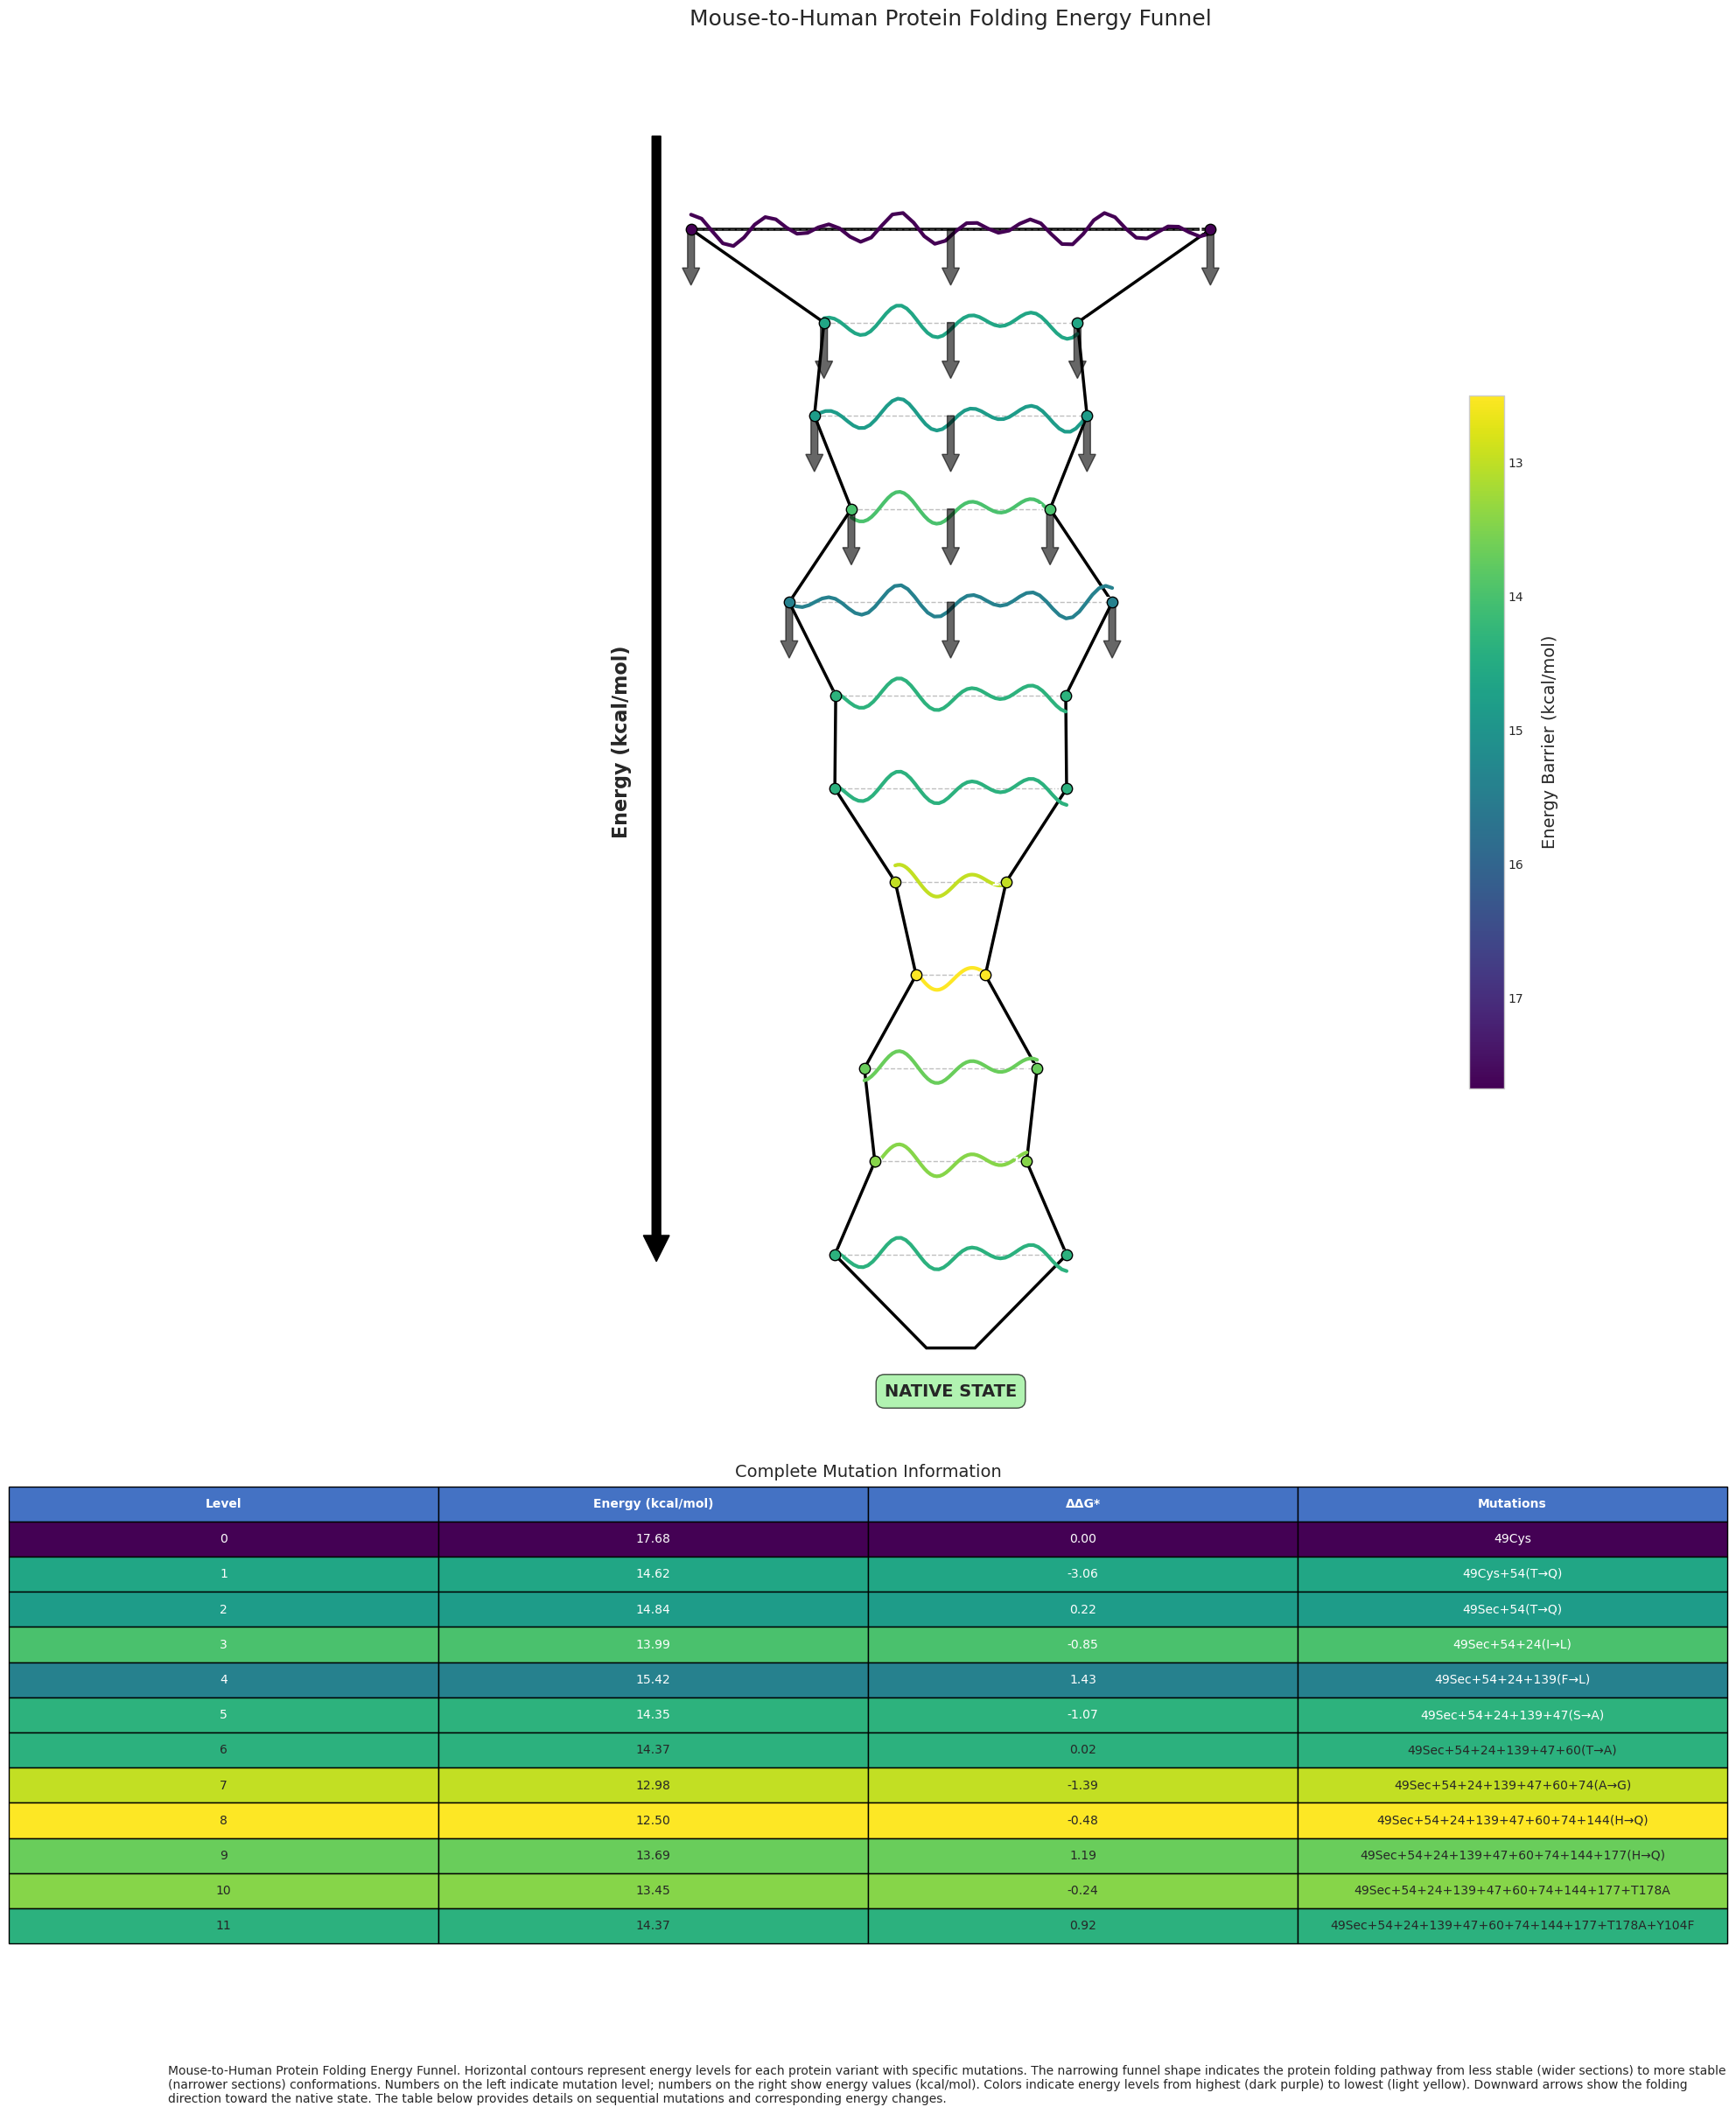

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pandas as pd

# Set plotting style for better readability
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50, 13.69, 13.45, 14.37])
mutations = [
    "49Cys",
    "49Cys+54(T→Q)",
    "49Sec+54(T→Q)",
    "49Sec+54+24(I→L)",
    "49Sec+54+24+139(F→L)",
    "49Sec+54+24+139+47(S→A)",
    "49Sec+54+24+139+47+60(T→A)",
    "49Sec+54+24+139+47+60+74(A→G)",
    "49Sec+54+24+139+47+60+74+144(H→Q)",
    "49Sec+54+24+139+47+60+74+144+177(H→Q)",
    "49Sec+54+24+139+47+60+74+144+177+T178A",
    "49Sec+54+24+139+47+60+74+144+177+T178A+Y104F"
]

# Calculate ΔΔG* values (difference from preceding level)
ddg_values = [0]  # First level has no preceding level
for i in range(1, len(barriers)):
    ddg = barriers[i] - barriers[i-1]
    ddg_values.append(ddg)

# Create a figure with 2 rows
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Create a color scheme that makes sense - gradient based on energy levels
norm = plt.Normalize(min(barriers), max(barriers))
cmap = plt.cm.viridis_r  # Using viridis colormap (reversed)
colors = [cmap(norm(barrier)) for barrier in barriers]

# Main funnel plot
ax_funnel = plt.subplot(gs[0])

# Create funnel shape
funnel_top = 6      # Width at the top
funnel_bottom = 0.8  # Width at the bottom
funnel_height = 14   # Total height
spacing = funnel_height / (len(levels) + 1)  # Space between levels

# Calculate y-positions for each level (top to bottom)
y_positions = [funnel_height - (i+1) * spacing for i in range(len(levels))]
y_positions.append(0)  # Add bottom position for native state

# Calculate widths for each level - proportional to energy
widths = []
for barrier in barriers:
    # Convert energy to width (higher energy = wider funnel)
    width_factor = (barrier - min(barriers)) / (max(barriers) - min(barriers))
    width = funnel_bottom + width_factor * (funnel_top - funnel_bottom)
    widths.append(width)
    
# Add native state at the bottom (narrowest point)
widths.append(funnel_bottom * 0.7)

# Draw funnel outline
x_points = []
y_points = []

# Right side (top to bottom)
for i in range(len(widths)):
    x_points.append(widths[i]/2)
    y_points.append(y_positions[i])

# Left side (bottom to top) - add points in reverse
for i in range(len(widths)-1, -1, -1):
    x_points.append(-widths[i]/2)
    y_points.append(y_positions[i])

# Close the path
x_points.append(widths[0]/2)
y_points.append(y_positions[0])

# Create a path for the funnel outline
funnel_path = Path(list(zip(x_points, y_points)))
funnel_patch = patches.PathPatch(funnel_path, facecolor='none', edgecolor='black', linewidth=2.5)
ax_funnel.add_patch(funnel_patch)

# Add a clear label for the native state at the bottom
ax_funnel.text(0, -0.5, "NATIVE STATE", fontsize=14, fontweight='bold', ha='center', va='center',
        bbox=dict(facecolor='lightgreen', alpha=0.7, boxstyle='round,pad=0.5'))

# Create the level contours (horizontal lines with bumps)
for i in range(len(levels)):
    # Energy contour coordinates
    y = y_positions[i]
    width = widths[i]
    
    # Basic horizontal line
    x_left = -width/2
    x_right = width/2
    
    # Create points for a bumpy line representing energy landscape
    x_bumps = np.linspace(x_left, x_right, 50)
    y_bumps = y + np.sin(x_bumps * 8) * 0.12 - np.cos(x_bumps * 5) * 0.08  # Add waves (reduced amplitude)
    
    # Plot the bumpy energy landscape level
    ax_funnel.plot(x_bumps, y_bumps, '-', color=colors[i], linewidth=3.0, zorder=3)
    
    # Add a horizontal marker line
    ax_funnel.plot([x_left, x_right], [y, y], '--', color='gray', alpha=0.5, linewidth=1, zorder=2)

    # Add level markers
    # Left side - level number
    ax_funnel.scatter(x_left, y, s=80, color=colors[i], edgecolor='black', zorder=5)
    ax_funnel.text(x_left, y, f"{i}", fontsize=10, ha='center', va='center', 
                  fontweight='bold', color='white')
    
    # Right side - energy value
    ax_funnel.scatter(x_right, y, s=80, color=colors[i], edgecolor='black', zorder=5)
    ax_funnel.text(x_right, y, f"{barriers[i]:.1f}", fontsize=10, ha='center', va='center',
                  fontweight='bold', color='white')

# Add arrows showing folding direction
arrow_count = 15
for i in range(arrow_count):
    # Determine arrow starting point
    level = int(i / 3) if int(i / 3) < len(levels) else len(levels) - 1
    
    y_start = y_positions[level] 
    x_fraction = (i % 3) / 2.0  # Distribute horizontally
    
    width = widths[level]
    x_start = -width/2 + width * x_fraction
    
    # Draw the arrow
    ax_funnel.arrow(x_start, y_start, 0, -spacing*0.6, width=0.08, 
              head_width=0.2, head_length=0.2, 
              fc='black', ec='black', alpha=0.6,
              length_includes_head=True, zorder=4)

# Add clear axis labels
# Energy axis (vertical)
ax_funnel.text(-funnel_top/2 - 0.8, funnel_height/2, "Energy (kcal/mol)", 
        fontsize=16, rotation=90, va='center', ha='center', fontweight='bold')
ax_funnel.arrow(-funnel_top/2 - 0.4, funnel_height, 0, -funnel_height + 1, width=0.1, 
        head_width=0.3, head_length=0.3, fc='black', ec='black',
        length_includes_head=True)

# Set up funnel axes
ax_funnel.set_xlim(-funnel_top/2 - 2, funnel_top/2 + 2)
ax_funnel.set_ylim(-1, funnel_height + 1)
ax_funnel.set_aspect('equal')
ax_funnel.axis('off')  # Hide the axes

# Add a legend explaining the color gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_funnel, orientation='vertical', 
                   pad=0.05, shrink=0.5, aspect=20)
cbar.set_label('Energy Barrier (kcal/mol)', rotation=90, labelpad=15)
cbar.ax.invert_yaxis()  # Invert so lower (better) values are at the bottom

# Add title to the funnel
ax_funnel.set_title("Mouse-to-Human Protein Folding Energy Funnel", fontsize=18, pad=20)

# Create table below the funnel
ax_table = plt.subplot(gs[1])

# Create a DataFrame for the table
data = {
    'Level': levels,
    'Energy (kcal/mol)': [f"{b:.2f}" for b in barriers],
    'ΔΔG*': [f"{d:.2f}" for d in ddg_values],
    'Mutations': mutations
}
df = pd.DataFrame(data)

# Create the table
table = ax_table.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Make rows taller

# Style the header row
for j in range(len(df.columns)):
    table[(0, j)].set_facecolor('#4472C4')
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# Style data rows based on their energy level
for i in range(len(levels)):
    for j in range(len(df.columns)):
        cell = table[(i+1, j)]
        cell.set_facecolor(colors[i])
        # Make text white for cells with dark backgrounds
        if i < len(levels)/2:  # First half (higher levels with lower energy)
            cell.set_text_props(color='white')

# Hide the axes for the table
ax_table.axis('off')
ax_table.set_title("Complete Mutation Information", fontsize=14)

# Add footnotes at the bottom of the figure
footnote_text = """
Mouse-to-Human Protein Folding Energy Funnel. Horizontal contours represent energy levels for each protein variant with specific mutations. The narrowing funnel shape indicates the protein folding pathway from less stable (wider sections) to more stable (narrower sections) conformations. Numbers on the left indicate mutation level; numbers on the right show energy values (kcal/mol). Colors indicate energy levels from highest (dark purple) to lowest (light yellow). Downward arrows show the folding direction toward the native state. The table below provides details on sequential mutations and corresponding energy changes.
"""

fig.text(0.1, 0.01, footnote_text, wrap=True, fontsize=10)

plt.tight_layout(rect=[0, 0.08, 1, 0.98], h_pad=2)  # Adjust layout to leave room for footnote
plt.savefig('mouse_to_human_energy_funnel_JACS.png', dpi=300, bbox_inches='tight')
plt.show()

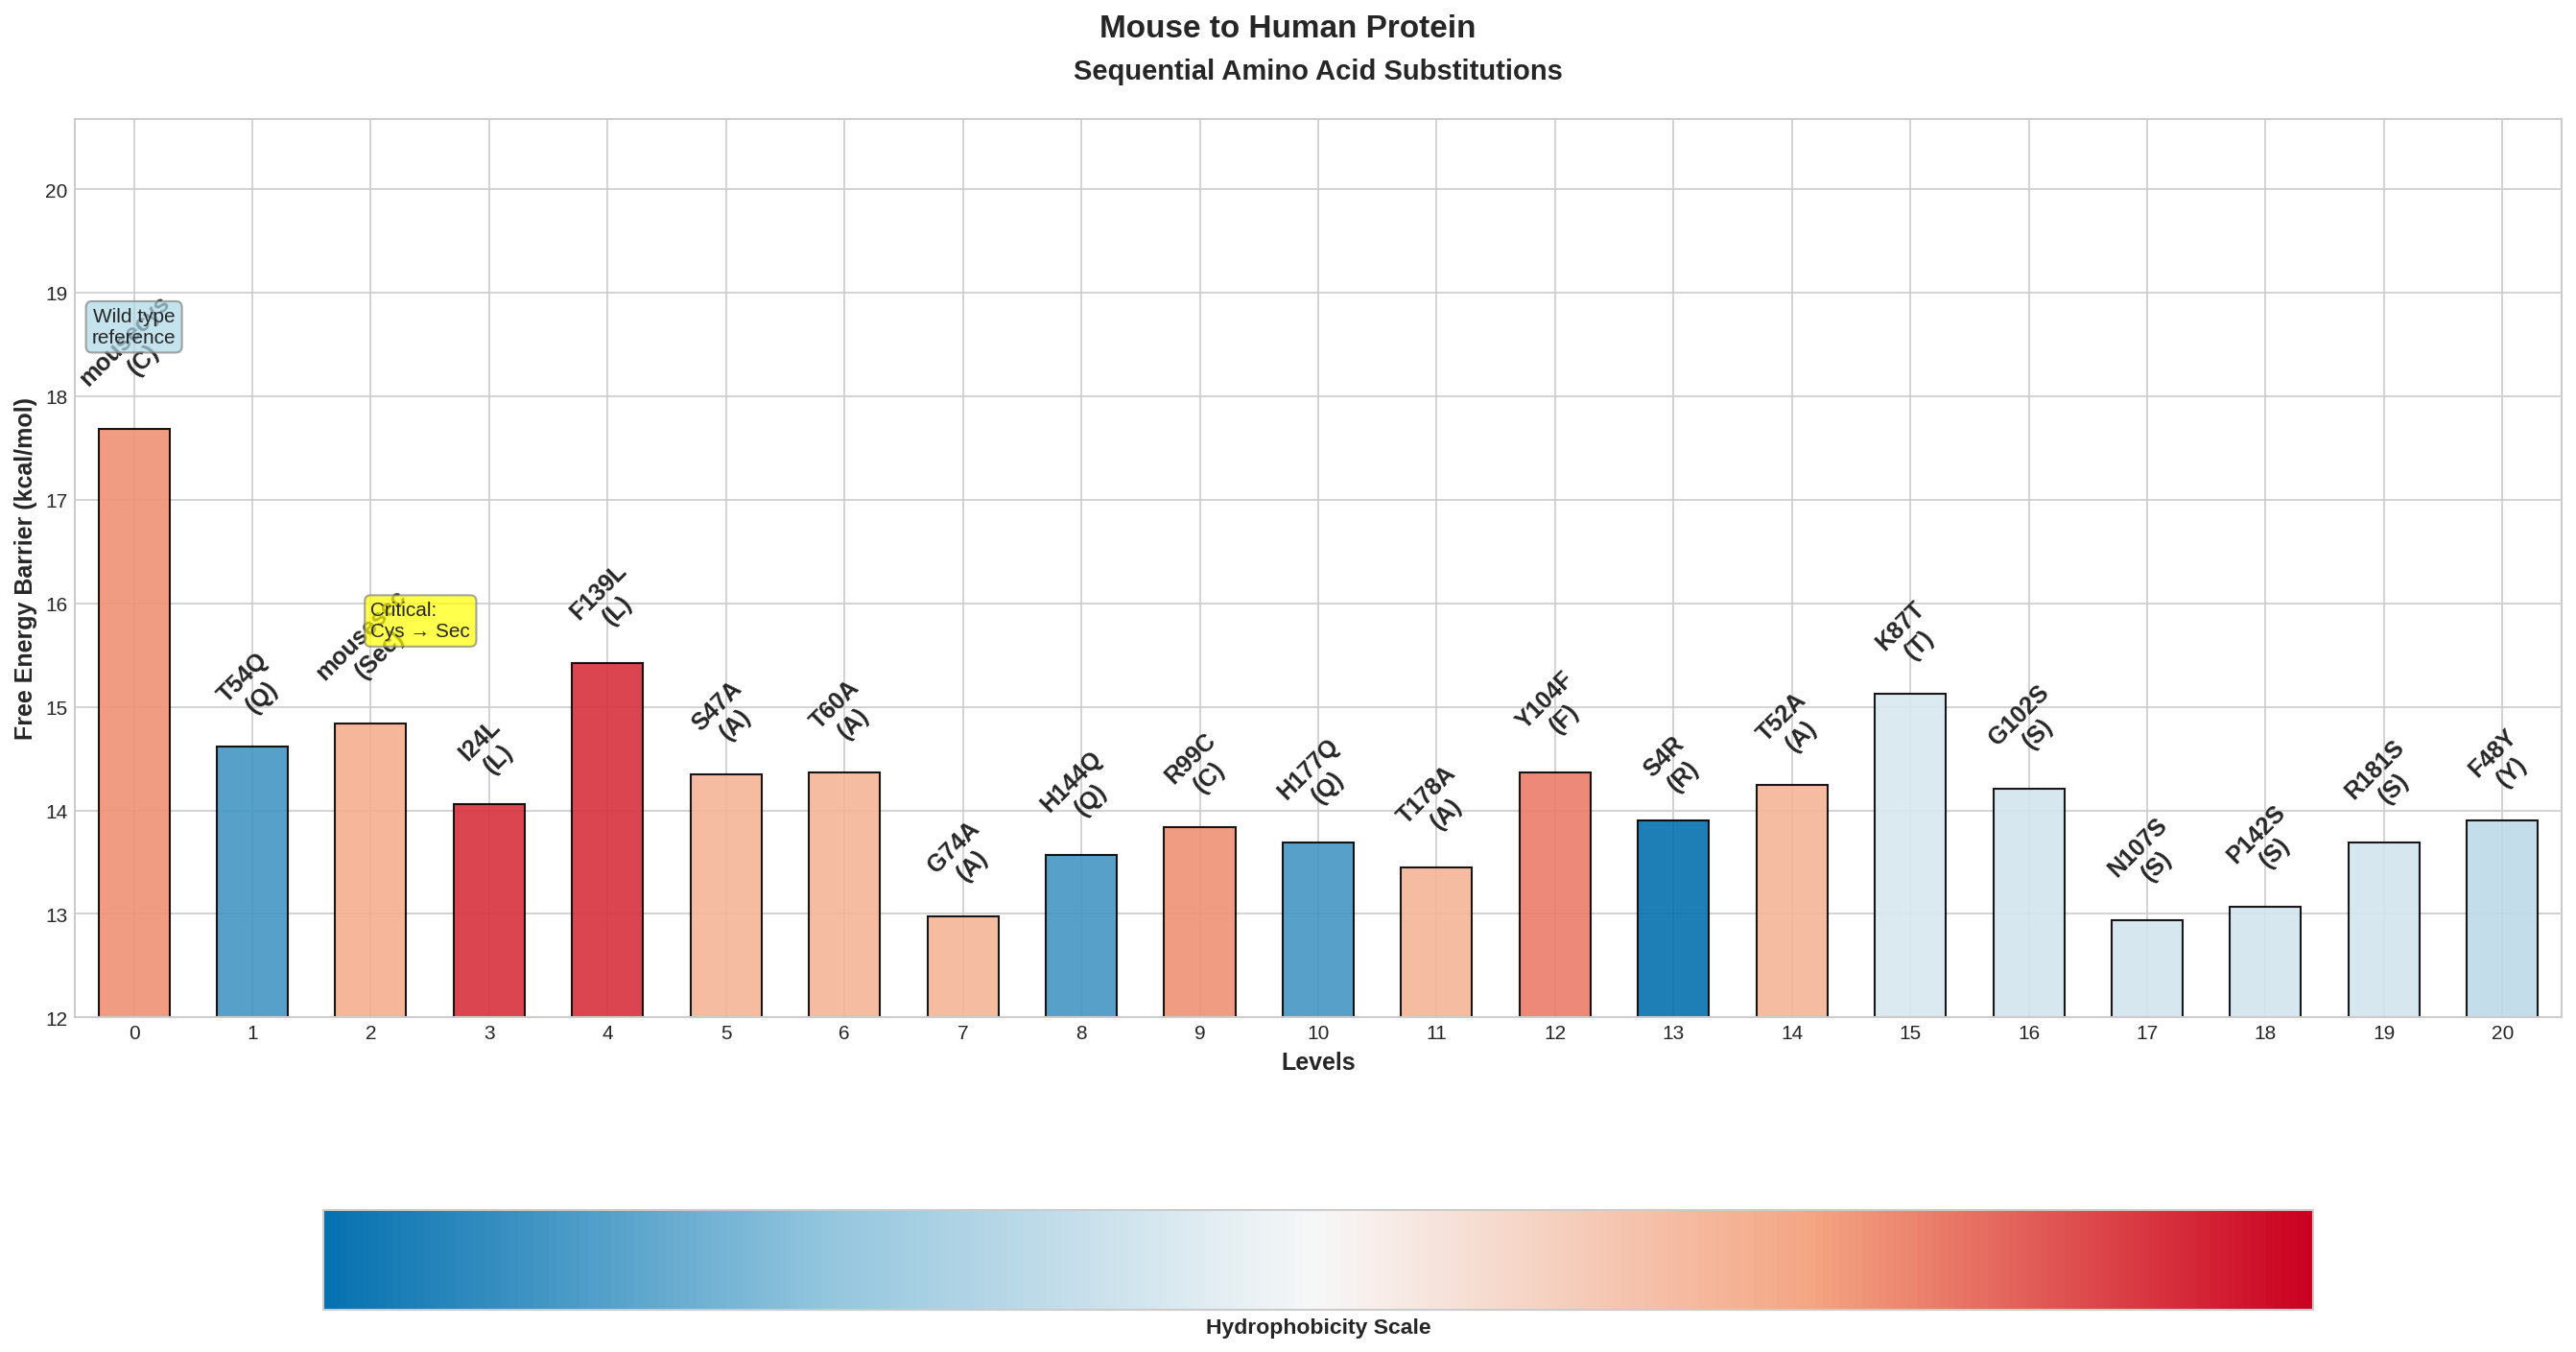

DETAILED HYDROPHOBICITY ANALYSIS:
Level | Mutation | Amino Acid | Hydrophobicity | Property
    0 | mousecys | C          |         2.5 | Hydrophobic
    1 | T54Q     | Q          |        -3.5 | Very Hydrophilic
    2 | mousesec | Sec        |         2.0 | Hydrophobic
    3 | I24L     | L          |         3.8 | Very Hydrophobic
    4 | F139L    | L          |         3.8 | Very Hydrophobic
    5 | S47A     | A          |         1.8 | Hydrophobic
    6 | T60A     | A          |         1.8 | Hydrophobic
    7 | G74A     | A          |         1.8 | Hydrophobic
    8 | H144Q    | Q          |        -3.5 | Very Hydrophilic
    9 | R99C     | C          |         2.5 | Hydrophobic
   10 | H177Q    | Q          |        -3.5 | Very Hydrophilic
   11 | T178A    | A          |         1.8 | Hydrophobic
   12 | Y104F    | F          |         2.8 | Hydrophobic
   13 | S4R      | R          |        -4.5 | Very Hydrophilic
   14 | T52A     | A          |         1.8 | Hydrophobic
   15 | 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Use a clean style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure - make it wider for horizontal layout
fig, ax = plt.subplots(figsize=(18, 10), dpi=150)

# Define corrected data with proper mutation sequence
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
barriers = np.array([17.68, 14.62, 14.84, 14.06, 15.42, 14.35, 14.37, 12.98, 13.57, 13.84, 13.69, 13.45, 14.37, 
                     13.90, 14.25, 15.13, 14.21, 12.94, 13.07, 13.69, 13.90])

# Add amino acid properties with corrected values
hydrophobicity = {
    'A': 1.8,   # Ala - hydrophobic
    'R': -4.5,  # Arg - very hydrophilic  
    'N': -3.5,  # Asn - hydrophilic
    'D': -3.5,  # Asp - hydrophilic
    'C': 2.5,   # Cys - moderately hydrophobic
    'Q': -3.5,  # Gln - hydrophilic
    'E': -3.5,  # Glu - hydrophilic
    'G': -0.4,  # Gly - neutral
    'H': -3.2,  # His - hydrophilic
    'I': 4.5,   # Ile - very hydrophobic
    'L': 3.8,   # Leu - hydrophobic
    'K': -3.9,  # Lys - very hydrophilic
    'M': 1.9,   # Met - moderately hydrophobic
    'F': 2.8,   # Phe - hydrophobic
    'P': -1.6,  # Pro - hydrophilic
    'S': -0.8,  # Ser - hydrophilic
    'T': -0.7,  # Thr - hydrophilic
    'W': -0.9,  # Trp - hydrophilic
    'Y': -1.3,  # Tyr - hydrophilic
    'V': 4.2,   # Val - very hydrophobic
    'Sec': 2.0  # Selenocysteine - moderately hydrophobic
}

# Extract the actual amino acid changes from the mutation labels
mutation_changes = [
    'C',    # 0: mousecys (starting with Cys)
    'Q',    # 1: +T54Q (Thr→Gln)  
    'Sec',  # 2: +mousesec (Cys→Sec)
    'L',    # 3: +I24L (Ile→Leu)
    'L',    # 4: +F139L (Phe→Leu)
    'A',    # 5: +S47A (Ser→Ala)
    'A',    # 6: +T60A (Thr→Ala)
    'A',    # 7: +G74A (Gly→Ala)
    'Q',    # 8: +H144Q (His→Gln)
    'C',    # 9: +R99C (Arg→Cys)
    'Q',    # 10: +H177Q (His→Gln)
    'A',    # 11: +T178A (Thr→Ala)
    'F',    # 12: +Y104F (Tyr→Phe)
    'R',    # 13: +S4R (Ser→Arg)
    'A',    # 14: +T52A (Thr→Ala)
    'T',    # 15: +K87T (Lys→Thr)
    'S',    # 16: +G102S (Gly→Ser)
    'S',    # 17: +N107S (Asn→Ser)
    'S',    # 18: +P142S (Pro→Ser)
    'S',    # 19: +R181S (Arg→Ser)
    'Y'     # 20: +F48Y (Phe→Tyr)
]

# Get hydrophobicity values for each mutation
mutation_hydrophobicity = [hydrophobicity[aa] for aa in mutation_changes]

# Create color mapping based on hydrophobicity values
min_hydro = -4.5  # Most hydrophilic (Arg)
max_hydro = 4.5   # Most hydrophobic (Ile)

# Normalize to 0-1 range
normalized_hydro = [(h - min_hydro) / (max_hydro - min_hydro) for h in mutation_hydrophobicity]

# Create a more vibrant colormap that shows the full spectrum
colors_list = ['#0571b0', '#92c5de', '#f7f7f7', '#f4a582', '#ca0020']  # Blue to white to red
cmap = LinearSegmentedColormap.from_list('hydrophobicity', colors_list, N=256)

# Map colors based on normalized hydrophobicity values
bar_colors = [cmap(norm_h) for norm_h in normalized_hydro]

# Create vertical bars with levels on x-axis
bar_heights = barriers
width = 0.6
bars = ax.bar(levels, bar_heights, width=width, color=bar_colors, 
              edgecolor='black', linewidth=1, alpha=0.9)

# Add mutation labels to the right of each bar
mutation_short_labels = [
    "mousecys", "T54Q", "mousesec", "I24L", "F139L", "S47A", "T60A", "G74A", 
    "H144Q", "R99C", "H177Q", "T178A", "Y104F", "S4R", "T52A", "K87T", 
    "G102S", "N107S", "P142S", "R181S", "F48Y"
]

for i, (level, height, label, aa_change) in enumerate(zip(levels, bar_heights, mutation_short_labels, mutation_changes)):
    # Place label on top of the bar with rotation to avoid overlap
    ax.text(level, height + 0.2, f"{label}\n({aa_change})", ha='center', va='bottom', 
            fontsize=12, fontweight='bold', rotation=45)

# Add critical mutation annotations
ax.annotate("Wild type\nreference", (0, barriers[0] + 0.8), fontsize=10,
           ha='center', va='bottom',
           bbox=dict(facecolor='lightblue', alpha=0.7, edgecolor='gray', 
                    boxstyle='round,pad=0.3'))
ax.annotate("Critical:\nCys → Sec", (2, barriers[2] + 0.8), fontsize=10,
           ha='left', va='bottom',
           bbox=dict(facecolor='yellow', alpha=0.7, edgecolor='gray', 
                    boxstyle='round,pad=0.3'))

# Add labels and title
ax.set_xlabel('Levels', fontsize=12, fontweight='bold')
ax.set_ylabel('Free Energy Barrier (kcal/mol)', fontsize=12, fontweight='bold')
ax.set_title('Sequential Amino Acid Substitutions', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(-0.5, 20.5)
ax.set_ylim(12, max(bar_heights) + 3)
ax.set_xticks(levels)
ax.set_xticklabels([str(i) for i in levels])

# Add hydrophobicity scale with CLEAR LABELS showing hydrophilic vs hydrophobic regions
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([min_hydro, max_hydro])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.8, pad=0.15)
cbar.set_label('Hydrophobicity Scale', fontsize=11, fontweight='bold')

# Remove all numerical tick labels from colorbar
cbar.ax.set_xticks([])
cbar.ax.set_xticklabels([])

# Add text annotations for the scale regions with better positioning
#cbar.ax.text(0.125, -1.2, 'HYDROPHILIC\n(< 0)', ha='center', va='top', 
             #fontsize=10, fontweight='bold', color='blue', transform=cbar.ax.transAxes)
#cbar.ax.text(0.875, -1.2, 'HYDROPHOBIC\n(> 0)', ha='center', va='top', 
             #fontsize=10, fontweight='bold', color='red', transform=cbar.ax.transAxes)

plt.suptitle('Mouse to Human Protein', 
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print detailed hydrophobicity information for each substitution
print("DETAILED HYDROPHOBICITY ANALYSIS:")
print("=" * 60)
print("Level | Mutation | Amino Acid | Hydrophobicity | Property")
print("=" * 60)

for i, (aa, hydro, norm, label) in enumerate(zip(mutation_changes, mutation_hydrophobicity, normalized_hydro, mutation_short_labels)):
    if hydro <= -3.0:
        property_desc = "Very Hydrophilic"
    elif hydro <= -1.0:
        property_desc = "Hydrophilic"
    elif hydro <= 1.0:
        property_desc = "Neutral"
    elif hydro <= 3.0:
        property_desc = "Hydrophobic"
    else:
        property_desc = "Very Hydrophobic"
    
    print(f"{i:5d} | {label:8s} | {aa:10s} | {hydro:11.1f} | {property_desc}")

print("=" * 60)

In [ ]:
0 mousecys 17.68 kcal/mol
1 mousecys + T54Q  14.62 kcal/mol
2 mousecys + T54Q + mousesec 14.84 kcal/mol
3 mousesec + T54Q + I24L 14.06 kcal/mol
4 mousesec + T54Q + I24L + F139L  15.42 kcal/mol
5 mousesec + T54Q + I24L + F139L + S47A 14.35 kcal/mol
6 mousesec + T54Q + I24L + F139L + S47A + T60A 14.37 kcal/mol
7 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A 12.98 kcal/mol
8 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q   13.57 kcal/mol                                            
9 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C   13.84 kcal/mol
10 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q 13.69 kcal/mol
11 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A 13.45 kcal/mol
12 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F 14.37 kcal/mol
13 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R 13.90 kcal/mol
14 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A 14.25 kcal/mol
15 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T 15.13 kcal/mol
16 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T + G102S 14.21 kcal/mol
17 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T + G102S + N107S 12.94 kcal/mol
18 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T + G102S + N107S + P142S  13.07 kcal/mol
19 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T + G102S + N107S + P142S + R181S 13.69 kcal/mol
20 mousesec + T54Q + I24L + F139L + S47A + T60A + G74A + H144Q + R99C + H177Q + T178A + Y104F + S4R + T52A + K87T + G102S + N107S + P142S + R181S + F48Y 13.90 kcal/mol